# Predicción del voto en EEUU 

---------------------------------------------------------

El objetivo de este estudio es analizar la capacidad de una serie de variable demográficas para predecir el voto de los estadounidenses. Las variables con las que se va a trabajar son edad, género, nivel educativo, nivel de ingresos, raza, confianza en el gobierno, interés por la política, grado de acuerdo con el sistema democrático y grado de acuerdo con el sistema democrático y con el sistema dictatorial. 

Se va a trabajar con una base de datos del grupo fivethirtyeight (https://data.fivethirtyeight.com/).

----------------------------------------------------

### BASE DE DATOS Y PREPROCESAMIENTO

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import scipy

In [2]:
df=pd.read_csv('nonvoters.csv')

In [3]:
df=df.loc[:,['race','gender','income_cat','voter_category','ppage','educ','Q25','Q9_1','Q9_2','Q8_1','Q30','Q23']]

In [4]:
df.rename(columns={'race':'raza','gender':'genero','income_cat':'ingresos','voter_category':'tipo_votante','Q23':'voto','ppage':'edad','Q8_1':'confianza_gobierno' ,'Q25':'interes_politica', 'Q9_1': 'acuerdo_democracia','Q9_2': 'acuerdo_dictadura', 'Q30':'ideologia'},inplace=True)

In [5]:
indexNames = df[ (df['raza'] == -1) | (df['genero'] == -1) | (df['ingresos'] == -1)| (df['tipo_votante'] == -1) | (df['educ'] == -1) | (df['edad'] == -1) | (df['voto'] == -1) |
              (df['ideologia'] == -1) | (df['confianza_gobierno'] == -1) |(df['interes_politica'] == -1) | (df['acuerdo_democracia'] == -1) | (df['acuerdo_dictadura'] == -1) ].index
df.drop(indexNames , inplace=True)
df.reset_index(drop=True,inplace=True)

In [6]:
df.head()

,raza,genero,ingresos,tipo_votante,edad,educ,interes_politica,acuerdo_democracia,acuerdo_dictadura,confianza_gobierno,ideologia,voto
0,White,Female,$75-125k,always,73,College,1,2,2,3,2,2
1,White,Female,$125k or more,always,90,College,3,1,1,2,3,1
2,White,Male,$125k or more,sporadic,53,College,2,1,2,3,2,2
3,Black,Female,$40-75k,sporadic,58,Some college,2,1,2,3,2,2
4,White,Male,$40-75k,always,81,High school or less,1,1,4,1,1,1


In [7]:
# Covertimos a categóricas voto e ideología
df.loc[:,'voto']=df.loc[:,'voto'].replace(1,'Trump')
df.loc[:,'voto']=df.loc[:,'voto'].replace(2,'Biden')
df.loc[:,'voto']=df.loc[:,'voto'].replace(3,'Unsure')
df.loc[:,'ideologia']=df.loc[:,'ideologia'].replace(1,'Republican')
df.loc[:,'ideologia']=df.loc[:,'ideologia'].replace(2,'Democrat')
df.loc[:,'ideologia']=df.loc[:,'ideologia'].replace(3,'Independent')
df.loc[:,'ideologia']=df.loc[:,'ideologia'].replace(4,'Independent')
df.loc[:,'ideologia']=df.loc[:,'ideologia'].replace(5,'No prefence')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5628 entries, 0 to 5627
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   raza                5628 non-null   object
 1   genero              5628 non-null   object
 2   ingresos            5628 non-null   object
 3   tipo_votante        5628 non-null   object
 4   edad                5628 non-null   int64 
 5   educ                5628 non-null   object
 6   interes_politica    5628 non-null   int64 
 7   acuerdo_democracia  5628 non-null   int64 
 8   acuerdo_dictadura   5628 non-null   int64 
 9   confianza_gobierno  5628 non-null   int64 
 10  ideologia           5628 non-null   object
 11  voto                5628 non-null   object
dtypes: int64(5), object(7)
memory usage: 527.8+ KB


-------------------------------------------

### ANÁLISIS UNIVARIANTE

In [9]:
# Descriptivos de las variables cuantitativas:
df.describe()

,edad,interes_politica,acuerdo_democracia,acuerdo_dictadura,confianza_gobierno
count,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000
mean,51.669332,1.840974,1.540334,2.583689,2.780917
std,17.083002,0.896122,0.709408,0.959976,1.121297
min,22.000000,1.000000,1.000000,1.000000,1.000000
25%,36.000000,1.000000,1.000000,2.000000,2.000000
50%,54.000000,2.000000,1.000000,2.000000,3.000000
75%,65.000000,2.000000,2.000000,3.000000,4.000000
max,94.000000,4.000000,4.000000,4.000000,4.000000


In [10]:
# Descriptivos de las variables categóricas:
df.describe(include=object) 

,raza,genero,ingresos,tipo_votante,educ,ideologia,voto
count,5628,5628,5628,5628,5628,5628,5628
unique,4,2,4,3,3,4,3
top,White,Male,$75-125k,sporadic,College,Democrat,Biden
freq,3588,2846,1581,2501,2285,1967,2737


##### Estudio de la VD (voto)

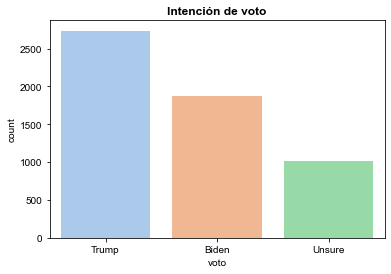

In [11]:
sns.countplot(data= df, x= 'voto',  palette='pastel')
plt.ylabel('count')
plt.title('Intención de voto', fontweight = 'bold')
plt.xticks([0,1,2], labels=['Trump', 'Biden','Unsure'])
sns.set_style('whitegrid')
plt.show()

------------------------------------------------------

### Estudio univariante cuantitativas

In [12]:
# Función para representar la relación entre el voto y otra variable cuantitativa
def VotoPorVICuantitativa(df,VI):
    fig=plt.figure(figsize = (25,5))

    plt.subplot(1,4,1)
    sns.barplot(data = df, x = 'voto', y = VI, palette='pastel')
    sns.set_style('whitegrid')

    plt.subplot(1,4,2)
    sns.boxplot(data = df, x = 'voto', y = VI, palette='pastel')
    sns.set_style('whitegrid')

    plt.subplot(1,4,3)
    sns.kdeplot(data=df[df.voto=='Trump'], x= VI,  shade = True)
    sns.kdeplot(data=df[df.voto=='Biden'], x= VI,  shade = True)
    sns.kdeplot(data=df[df.voto=='Unsure'], x= VI,  shade = True)
    sns.set_style('whitegrid')

    plt.subplot(1,4,4)
    sns.violinplot(data= df, x= 'voto', y= VI, palette='pastel')
    sns.set_style('whitegrid')

    plt.subplots_adjust(wspace = 0.3)
    plt.suptitle('Voto por '+ VI,fontsize='20',fontweight = 'bold')
    plt.show()

In [13]:
# Contraste para evaluar la relación entre el voto y otra variable cuantitativa
def Contraste(df,VI):
    
    unsure=df[VI][df.voto=='Unsure']
    biden=df[VI][df.voto=='Biden']
    trump=df[VI][df.voto=='Trump']
        
    e1, p1 = scipy.stats.normaltest(df[VI])
    e2, p2 = scipy.stats.levene(unsure, biden)
    e3, p3 = scipy.stats.levene(unsure, trump)
    e4, p4 = scipy.stats.levene(biden, trump)
    
    print('La media de '+VI+' del grupo que votó a Trump es', round(np.mean(trump),2))
    print('La media de '+VI+' del grupo que votó a Biden es', round(np.mean(biden),2))
    print('La media de '+VI+' del grupo que no supo a quién votar es', round(np.mean(unsure),2))
    print('')
    
    if ((p1 <0.05) & (p2 < 0.05) & (p3 < 0.05) & (p4 < 0.05)):
        print('No se han cumplido los supuestos por lo que aplicamos la prueba no paramétrica Kruskal Wallis')
        e, p = scipy.stats.kruskal(unsure,biden,trump)
        if p <0.05:
            print('Rechazo H0. Hay evidencia a favor de que al menos un grupo de la votantes tiene una media de '+VI+'  significativamente diferentes al resto.')
            print('Esto significa que las variables están relacionadas y que, por lo tanto, la '+VI+' tendrá capacidad predictiva del voto.' )

        else:
            print('No podemos rechazar H0. No podemos afirmar que las medias de '+VI+' en cada grupo de votante sean significativamente diferentes.')
            print('Esto significa que no parece que las variables estén relacionadas y que por tanto, la variable '+VI+' no tendrá capacidad predictiva del voto' )
    else:
        print('Se han cumplido los supuestos por lo que aplicamos la prueba paramétrica ANOVA.')
        e, p = scipy.stats.f_oneway(unsure,biden,trump)
        if p <0.05:
            print('Rechazo H0. Hay evidencia a favor de que al menos un grupo de la votantes tiene una media de '+VI+'  significativamente diferentes al resto.')
            print('Esto significa que las variables están relacionadas y que, por lo tanto, la variable '+VI+' tendrá capacidad predictiva del voto.' )
        else:
            print('No podemos rechazar H0. No podemos afirmar que las medias de '+VI+' en cada grupo de votante sean significativamente diferentes.')
            print('Esto significa que no parece que las variables estén relacionadas y que por tanto, la '+VI+' no tendrá capacidad predictiva del voto' )


##### Covariable edad

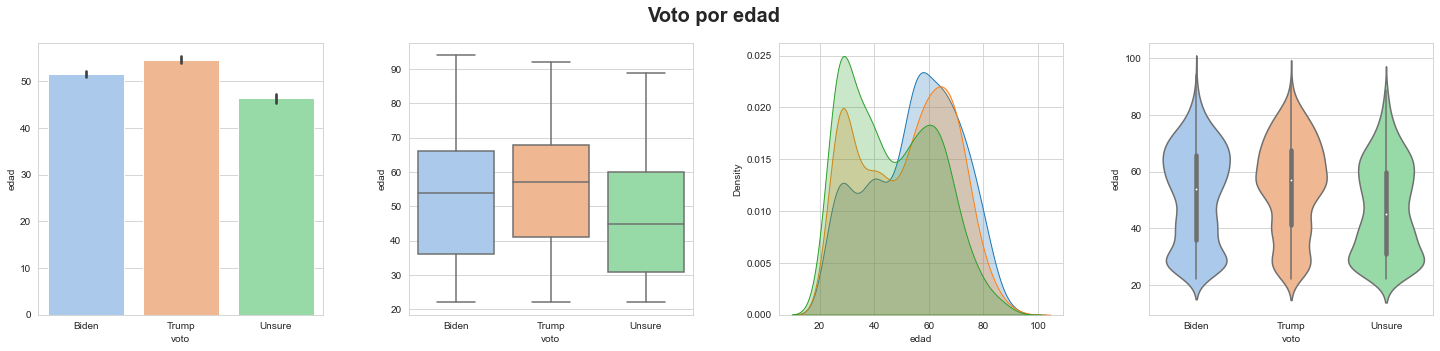

In [14]:
VotoPorVICuantitativa(df,'edad')

In [15]:
VI='edad'
Contraste(df, VI)

La media de edad del grupo que votó a Trump es 54.64
La media de edad del grupo que votó a Biden es 51.56
La media de edad del grupo que no supo a quién votar es 46.45

Se han cumplido los supuestos por lo que aplicamos la prueba paramétrica ANOVA.
Rechazo H0. Hay evidencia a favor de que al menos un grupo de la votantes tiene una media de edad  significativamente diferentes al resto.
Esto significa que las variables están relacionadas y que, por lo tanto, la variable edad tendrá capacidad predictiva del voto.


##### Covariable interés político

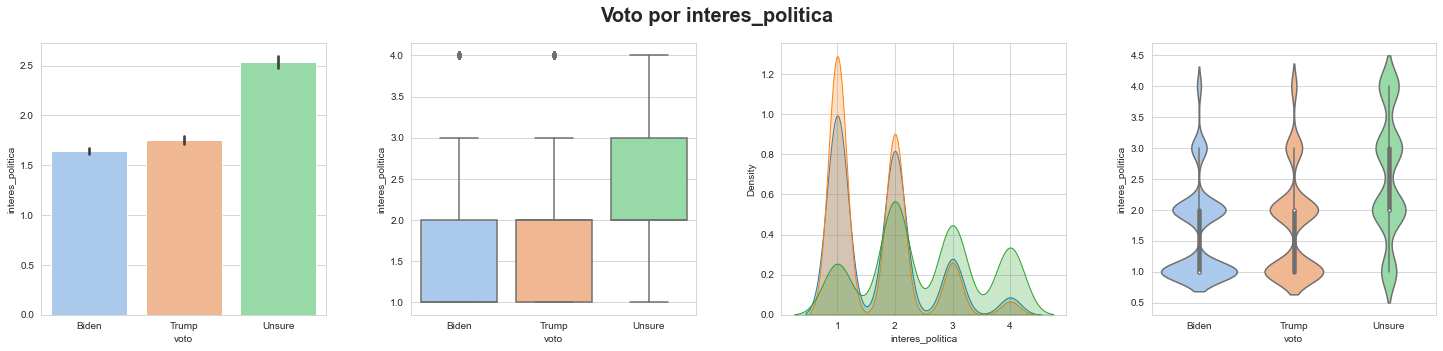

In [16]:
VotoPorVICuantitativa(df,'interes_politica')

In [17]:
VI='interes_politica'
Contraste(df, VI)

La media de interes_politica del grupo que votó a Trump es 1.75
La media de interes_politica del grupo que votó a Biden es 1.64
La media de interes_politica del grupo que no supo a quién votar es 2.54

Se han cumplido los supuestos por lo que aplicamos la prueba paramétrica ANOVA.
Rechazo H0. Hay evidencia a favor de que al menos un grupo de la votantes tiene una media de interes_politica  significativamente diferentes al resto.
Esto significa que las variables están relacionadas y que, por lo tanto, la variable interes_politica tendrá capacidad predictiva del voto.


##### Covariable estar de acuerdo con la democracia

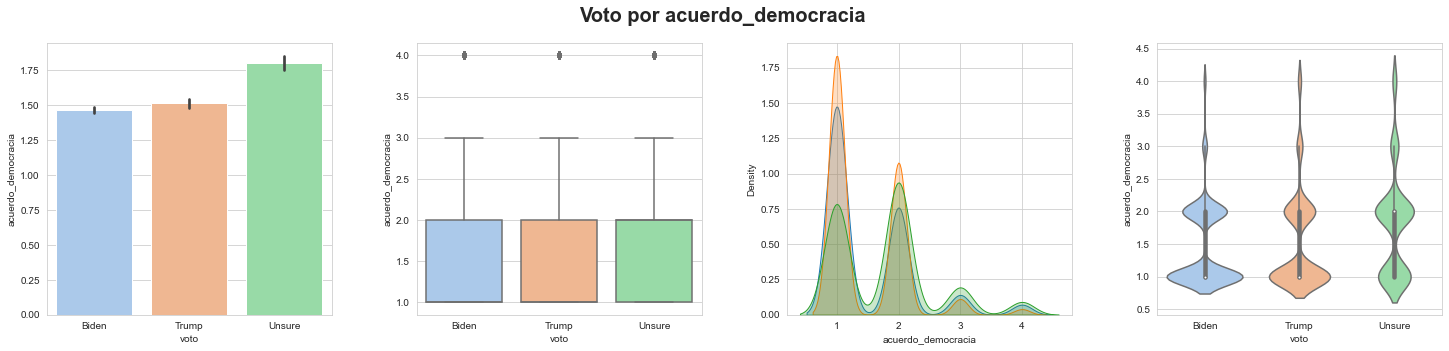

In [18]:
VotoPorVICuantitativa(df,'acuerdo_democracia')

In [19]:
VI='acuerdo_democracia'
Contraste(df, VI)

La media de acuerdo_democracia del grupo que votó a Trump es 1.51
La media de acuerdo_democracia del grupo que votó a Biden es 1.46
La media de acuerdo_democracia del grupo que no supo a quién votar es 1.8

No se han cumplido los supuestos por lo que aplicamos la prueba no paramétrica Kruskal Wallis
Rechazo H0. Hay evidencia a favor de que al menos un grupo de la votantes tiene una media de acuerdo_democracia  significativamente diferentes al resto.
Esto significa que las variables están relacionadas y que, por lo tanto, la acuerdo_democracia tendrá capacidad predictiva del voto.


##### Covariable estar de acuerdo con una dictadura

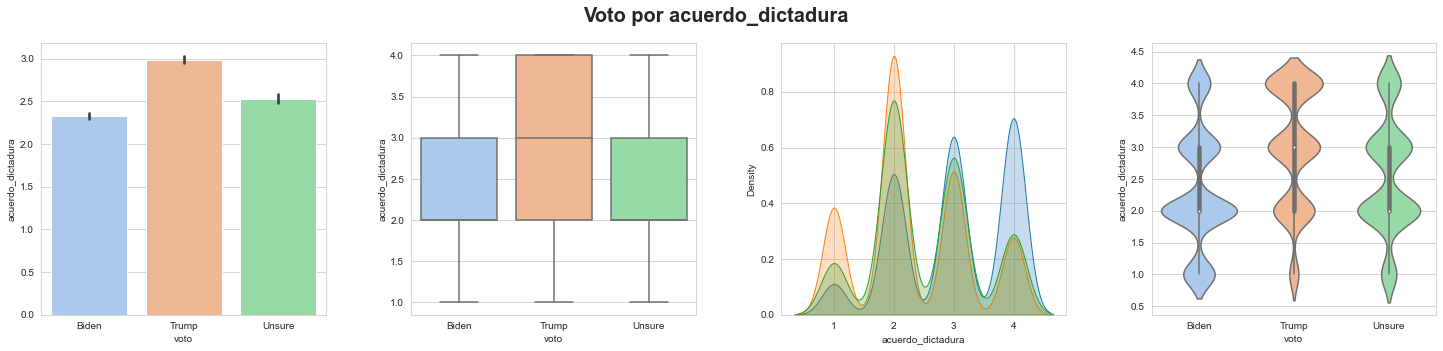

In [20]:
VotoPorVICuantitativa(df,'acuerdo_dictadura')

In [21]:
VI='acuerdo_dictadura'
Contraste(df, VI)

La media de acuerdo_dictadura del grupo que votó a Trump es 2.99
La media de acuerdo_dictadura del grupo que votó a Biden es 2.33
La media de acuerdo_dictadura del grupo que no supo a quién votar es 2.53

Se han cumplido los supuestos por lo que aplicamos la prueba paramétrica ANOVA.
Rechazo H0. Hay evidencia a favor de que al menos un grupo de la votantes tiene una media de acuerdo_dictadura  significativamente diferentes al resto.
Esto significa que las variables están relacionadas y que, por lo tanto, la variable acuerdo_dictadura tendrá capacidad predictiva del voto.


##### Covariable confianza en el gobierno

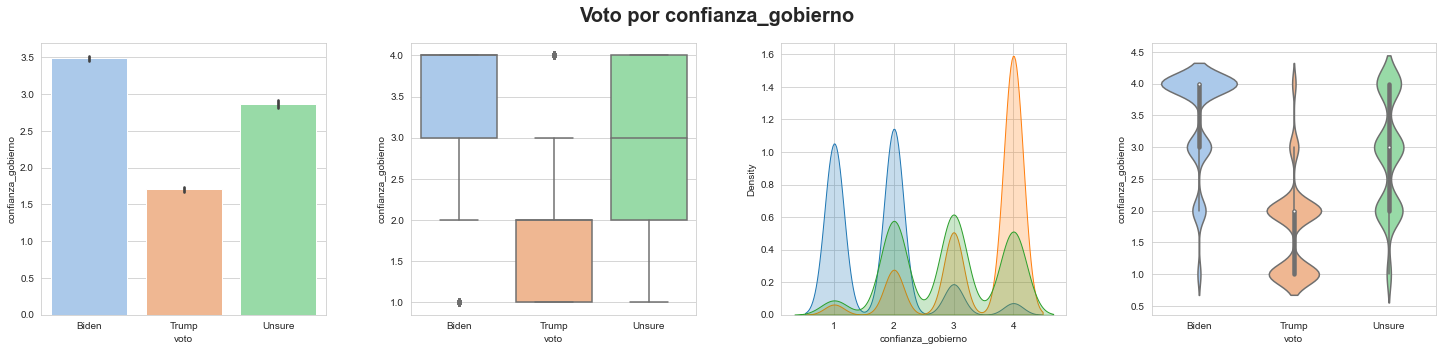

In [22]:
VotoPorVICuantitativa(df,'confianza_gobierno')

In [23]:
VI='confianza_gobierno'
Contraste(df, VI)

La media de confianza_gobierno del grupo que votó a Trump es 1.71
La media de confianza_gobierno del grupo que votó a Biden es 3.49
La media de confianza_gobierno del grupo que no supo a quién votar es 2.86

No se han cumplido los supuestos por lo que aplicamos la prueba no paramétrica Kruskal Wallis
Rechazo H0. Hay evidencia a favor de que al menos un grupo de la votantes tiene una media de confianza_gobierno  significativamente diferentes al resto.
Esto significa que las variables están relacionadas y que, por lo tanto, la confianza_gobierno tendrá capacidad predictiva del voto.


Todas las variables cuantitativas parecen estar relacionadas con la variable voto. De modo que todas se usarán para hacerlas predicciones.

-----------------------------------------------

### Estudio univariante categóricas

In [106]:
# Función para evaluar la relación entre el voto y otra variable categórica con gráfico y contraste
def VotoPorVICategorica(df,VI):
    
    plt.figure(figsize=(12,3))
    plt.subplot(1,2,1)
    sns.countplot(data = df, x = 'voto',  hue= VI, palette='pastel')
    sns.set_style('whitegrid')
    plt.title('Voto por '+ VI,fontsize='13',fontweight = 'bold')
    
    contigency= pd.crosstab(df['voto'], df[VI]) 
    
    plt.subplot(1,2,2)
    sns.heatmap(contigency, annot=True,center=True ,fmt='g' ,cmap='Pastel1_r',linecolor='grey', linewidths=0.5 )
    plt.title('Tabla de contingencia de voto y '+VI,fontsize='13',fontweight = 'bold')
    plt.show()

    chi, p, dof, ex = scipy.stats.chi2_contingency(contigency, correction=False)
    
    if (p <0.05):
        print('Rechazo H0. Existe una relación significativa entre el voto y '+ VI+'. Esto nos informa de que es muy probable que esta variable nos ayude a predecir el voto.')     
    else:
        print('No podemos rechazar H0. No podemos afirmar que haya una relación significativa entre el voto y '+VI+'. Esto nos informa de que es poco probable que esta variable nos ayude a predecir el voto.')

##### Covariable raza

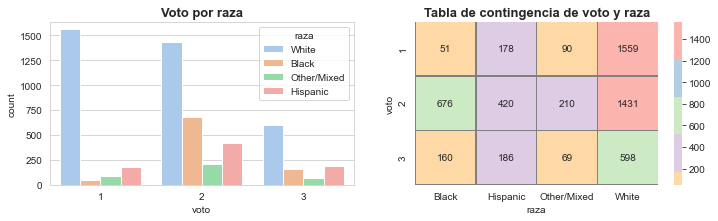

Rechazo H0. Existe una relación significativa entre el voto y raza. Esto nos informa de que es muy probable que esta variable nos ayude a predecir el voto.


In [107]:
VotoPorVICategorica(df,'raza')

##### Covariable tipo de votante

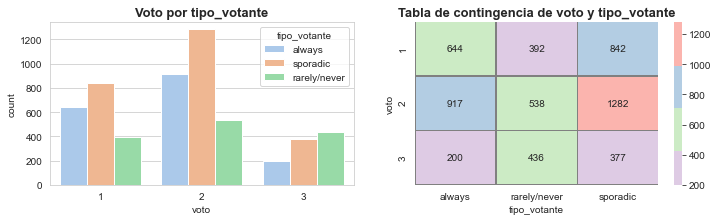

Rechazo H0. Existe una relación significativa entre el voto y tipo_votante. Esto nos informa de que es muy probable que esta variable nos ayude a predecir el voto.


In [108]:
VotoPorVICategorica(df,'tipo_votante')

##### Covariable nivel educativo

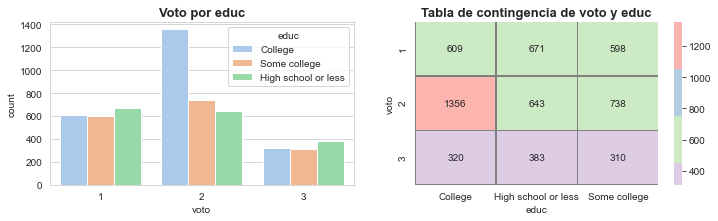

Rechazo H0. Existe una relación significativa entre el voto y educ. Esto nos informa de que es muy probable que esta variable nos ayude a predecir el voto.


In [109]:
VotoPorVICategorica(df,'educ')

##### Covariable género

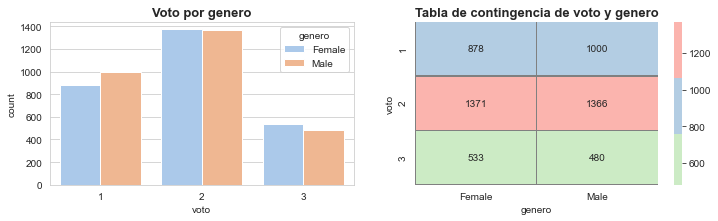

Rechazo H0. Existe una relación significativa entre el voto y genero. Esto nos informa de que es muy probable que esta variable nos ayude a predecir el voto.


In [110]:
VotoPorVICategorica(df,'genero')

Todas las variables categóricas parecen estar relacionadas con la variable voto. De modo que todas se usarán para hacerlas predicciones.

----------------------------------------------------

### ESTUDIO MULTIVARIANTE

##### Análisis de componentes principales

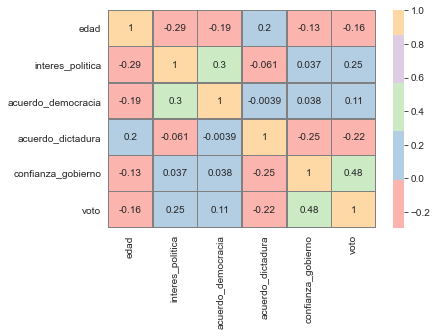

In [113]:
sns.heatmap(df.corr(), annot = True, center=True,cmap='Pastel1',linecolor='grey', linewidths=0.5)
plt.show()

<Figure size 360x360 with 0 Axes>

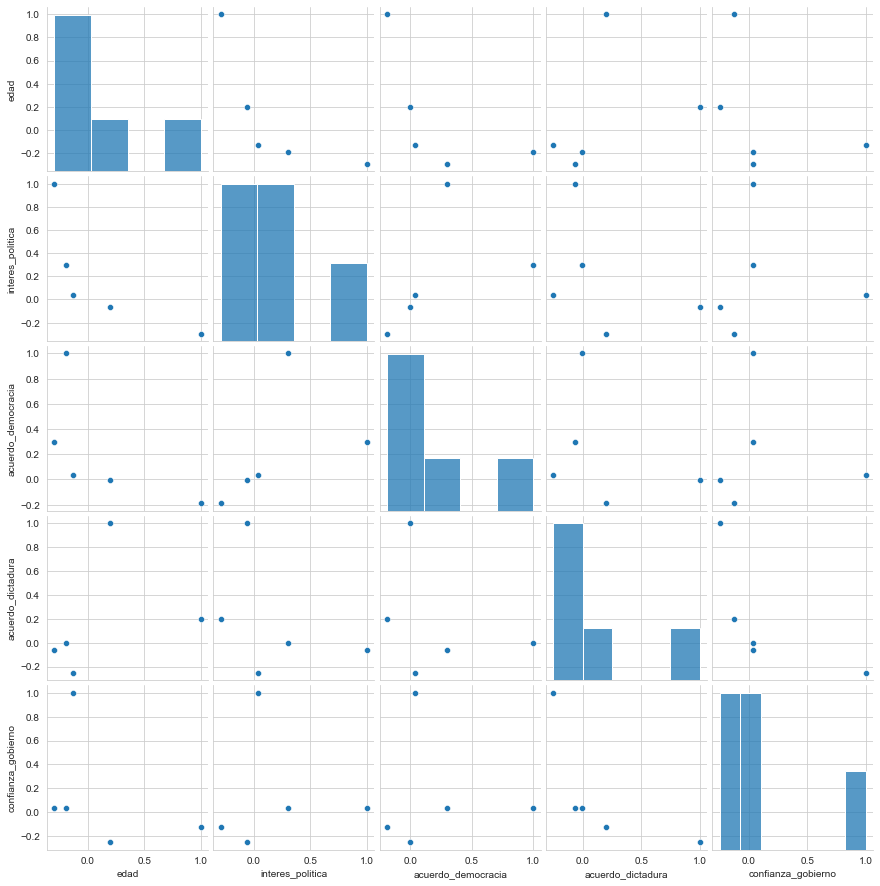

In [30]:
plt.figure(figsize=(5,5))
sns.pairplot(df.corr())
plt.show()

In [31]:
VD=df.loc[:,'voto']

In [32]:
dfCategoricas=df.loc[:,['raza','genero', 'ingresos', 'tipo_votante','educ','ideologia']]
dfCuantis=df.loc[:,['edad', 'interes_politica', 'acuerdo_democracia', 'acuerdo_dictadura','confianza_gobierno']]

In [33]:
# Convertimos las categóricas en dummies 
dummies1=pd.get_dummies(dfCategoricas.raza) 
dummies2=pd.get_dummies(dfCategoricas.genero) 
dummies3=pd.get_dummies(dfCategoricas.ingresos) 
dummies4=pd.get_dummies(dfCategoricas.tipo_votante) 
dummies5=pd.get_dummies(dfCategoricas.educ) 
#dummies6=pd.get_dummies(dfCategoricas.ideology) 

In [34]:
# Escalamos datos cuantitativos
scaler = StandardScaler()
cuantisEscalado = np.round(scaler.fit_transform(dfCuantis),1)
cuantisEscalado = pd.DataFrame(cuantisEscalado)
cuantisEscalado.rename(columns={0:'edad', 1:'interes_politica', 2:'acuerdo_democracia',3:'acuerdo_dictadura', 4:'confianza_gobierno'},inplace=True)

In [35]:
cat = dummies1.join(dummies2)
cat = cat.join(dummies3)
cat = cat.join(dummies4)
cat = cat.join(dummies5)
#cat = cat.join(dummies6)

In [36]:
dfFinal = cuantisEscalado.join(cat)

In [37]:
# Aplicación componentes principales
pca = PCA(n_components = 2)
componentes_principales = pca.fit_transform(dfFinal)

In [38]:
# Puntuación de cada persona en cada CP
cp = pd.DataFrame(componentes_principales,columns = ['PC1','PC2'])

In [39]:
# Propoción de varianza explicada por el modelo
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)
print(per_var)

[20.8 15.4]


In [40]:
# Pesos de las variables en cada componente
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=dfFinal.columns)
print(loadings)

                          PC1       PC2
edad                -0.537734  0.051911
interes_politica     0.510949  0.336489
acuerdo_democracia   0.454960  0.426494
acuerdo_dictadura   -0.329763  0.537868
confianza_gobierno   0.297185 -0.601021
Black                0.020385 -0.038789
Hispanic             0.032139 -0.012947
Other/Mixed          0.018232 -0.012676
White               -0.070756  0.064412
Female               0.021846  0.037860
Male                -0.021846 -0.037860
$125k or more       -0.034824 -0.053924
$40-75k             -0.001548  0.021013
$75-125k            -0.007987 -0.025224
Less than $40k       0.044359  0.058135
always              -0.098274 -0.025478
rarely/never         0.147267  0.056575
sporadic            -0.048993 -0.031097
College             -0.019883 -0.131317
High school or less  0.023996  0.114435
Some college        -0.004113  0.016882


##### ¿Nos serviría para una IA?

In [41]:
VD.replace('Trump',1, inplace=True)
VD.replace('Biden',2,inplace=True)
VD.replace('Unsure',3, inplace=True)

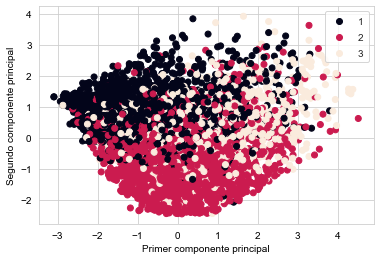

In [42]:
# Gráfico de dispersión
ax = plt.scatter(cp.PC1,cp.PC2, c=VD)
plt.xlabel('Primer componente principal',color = 'black')
plt.ylabel('Segundo componente principal',color = 'black')
plt.xticks(color='black')
plt.yticks(color='black')
plt.legend(*ax.legend_elements())
plt.show()

El 1 representa a Trump, el 2 a Biden y el 3 a los que no supieron a quíen votar.
En el gráfico de dispersión se puede observar como, a pesar de que estos dos CP sólo expliquen un 36.2% de la varianza, sí son capaces de dividir a los sujetos en los tres grupos de voto. De modo que el grupo de variables seleccionadas y transformadas en dos componentes principales sí presentan el potencial para hacer predicciones del voto de los estadounidenses.

##### ¿Cual es el numero de componentes óptimo con el que se representaría gran parte de la varianza original?

 Criterios para elegir el número adecuado de componentes:
- 1: Scree plot: enfrenta la propoción de varianza explicada y el número de componentes.Se elige extraer el número de CP donde se produzca un cambio de pendiente
- 2: Extraer el número de CP cuya varianza explicada acumulada alcance el 70% 
- 3: Regla de Kaisser (no recomendado): propone extraer el número de CP cuyos eigenvalues sean superiores a 1

In [43]:
# Aplicamos el modelo con el máximo de CP
pca = PCA(n_components = 11)
componentes_principales = pca.fit_transform(dfFinal)

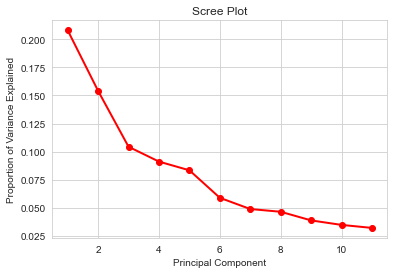

In [44]:
# Regla 1:
plt.subplot()
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [45]:
# Regla 2:
per_var_acumulada = np.cumsum(np.round(pca.explained_variance_ratio_ * 100, decimals = 1))
print(per_var_acumulada)

[20.8 36.2 46.6 55.7 64.  69.9 74.8 79.5 83.4 86.9 90.1]


In [46]:
# Regla 3:
print(pca.explained_variance_)

[1.68396277 1.24738349 0.84505133 0.73821241 0.67551361 0.47743875
 0.39668776 0.37694956 0.3147084  0.28233642 0.26070316]
